In [1]:
import sys
sys.path.append('/home/mmann1123/Documents/github/xr_fresh/')
import numpy as np
import dask.array as da
import xarray as xr
from xr_fresh.backends import Cluster
from xr_fresh.extractors import extract_features
from xr_fresh.transformers import Stackerizer 

from sklearn_xarray import wrap, Target
from sklearn_xarray.preprocessing import Splitter, Sanitizer, Featurizer
from sklearn_xarray.model_selection import CrossValidatorWrapper
from sklearn_xarray.datasets import load_wisdm_dataarray
from sklearn.preprocessing import StandardScaler, LabelEncoder,LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline


nrows = 100
ncols = 200
row_chunks = 50
col_chunks = 50

data = da.random.random(size=(1, nrows, ncols), chunks=(1, row_chunks, col_chunks))

def create_band(data, x, y, band_name):

    return xr.DataArray(data,
                        dims=('band', 'y', 'x'),
                        coords={'band': [band_name],
                                'y': y,
                                'x': x})

def create_coords(data, left, top, celly, cellx):
    nrows = data.shape[-2]
    ncols = data.shape[-1]
    right = left + cellx*ncols
    bottom = top - celly*nrows
    x = np.linspace(left, right, ncols) + cellx/2.0
    y = np.linspace(top, bottom, nrows) - celly/2.0
    
    return x, y

x, y = create_coords(data, 1000, 2000, 30, 30)

src = []

for time in ['t1', 't2', 't3']:

    src_t = xr.concat([create_band(data, x, y, band) for band in ['blue', 'green', 'red', 'nir']], dim='band')\
                    .expand_dims(dim='time')\
                    .assign_coords({'time': [time]})
    
    src.append(src_t)

src = xr.concat(src, dim='time')
src = src.chunk((len(src.time), 1, 350, 350))
src.attrs['nodatavals'] =  (-9999,)
print(src)

<xarray.DataArray 'random_sample-9686b2f1837998b86f03a146b458c595' (time: 3, band: 4, y: 100, x: 200)>
dask.array<rechunk-merge, shape=(3, 4, 100, 200), dtype=float64, chunksize=(3, 1, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) object 'blue' 'green' 'red' 'nir'
  * y        (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * x        (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * time     (time) object 't1' 't2' 't3'
Attributes:
    nodatavals:  (-9999,)


### Create time series features

In [2]:
%%time
complete_f =  {
                'abs_energy':[{}],       
                'mean_abs_change':[{}],  
                'variance_larger_than_standard_deviation':[{}],   
                'ratio_beyond_r_sigma':[{'r':1},{'r':2},{'r':3}],
                'large_standard_deviation':[{'r':0.5},{'r':1},{'r':2},{'r':3}],
                 'symmetry_looking':[{}],
                 'sum_values':[{}],
                 'autocorr':[{'lag':1},{'lag':2}],   
                 'ts_complexity_cid_ce':[{}],
                 'mean_change':[{}],  
                 'maximum':[{}],  
                 'median':[{}],
                 'minimum':[{}],
                }


# start cluster
cluster = Cluster()
cluster.start_large_object()

features = extract_features(xr_data= src,
                                feature_dict=complete_f,
                                band='blue', 
                                na_rm = True)
    
 
cluster.close()

<Client: 'inproc://192.168.86.95/19786/1' processes=1 threads=12, memory=134.76 GB>
go to http://localhost:8787/status for dask dashboard
Extracting:  abs_energy
Extracting:  mean_abs_change
Extracting:  variance_larger_than_standard_deviation
Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma
Extracting:  ratio_beyond_r_sigma
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  large_standard_deviation
Extracting:  symmetry_looking
Extracting:  sum_values
Extracting:  autocorr
Extracting:  autocorr
Extracting:  ts_complexity_cid_ce
Extracting:  mean_change
Extracting:  maximum
Extracting:  median
Extracting:  minimum
CPU times: user 2.22 s, sys: 174 ms, total: 2.39 s
Wall time: 3.54 s


In [3]:
features.shape
features

<xarray.DataArray 'random_sample-9686b2f1837998b86f03a146b458c595' (variable: 19, y: 100, x: 200)>
array([[[2.94824248, 1.36998842, 1.7642631 , ..., 0.12580789,
         0.07738728, 2.96975807],
        [0.16879644, 2.10395829, 1.18203927, ..., 2.63808061,
         0.1144952 , 0.45332   ],
        [0.98889861, 1.11602118, 2.14619094, ..., 0.5733773 ,
         0.53969679, 1.86404177],
        ...,
        [0.5809061 , 0.17140852, 1.4354097 , ..., 0.63065904,
         1.79201256, 1.58637806],
        [2.8607175 , 0.84368904, 0.30771978, ..., 0.00486862,
         0.08646211, 1.56646553],
        [0.4498145 , 0.11428309, 1.52862578, ..., 0.01172215,
         0.9755327 , 1.90067695]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.44004019, 0.23903174, 0.69171519, ..., 0.4584972 ,
         0.77287614, 0.72718133],
        [0.97651037, 0.53031093, 0.32027061, ..., 0.0402849 ,
         0.16976662, 0.72260306],
        [0.3872185 , 0.19517777, 0.71382206, ..., 0.06250907,
         0.57024343, 0.79596418]],

       [[0.99133622, 0.67576831, 0.76686876, ..., 0.20478272,
         0.16061058, 0.99494691],
        [0.23720345, 0.83744817, 0.62770462, ..., 0.93774208,
         0.19535881, 0.38872441],
        [0.57413663, 0.60992381, 0.84581143, ..., 0.43717933,
         0.42414494, 0.78825583],
        ...,
        [0.44004019, 0.23903174, 0.69171519, ..., 0.4584972 ,
         0.77287614, 0.72718133],
        [0.97651037, 0.53031093, 0.32027061, ..., 0.0402849 ,
         0.16976662, 0.72260306],
        [0.3872185 , 0.19517777, 0.71382206, ..., 0.06250907,
         0.57024343, 0.79596418]]])
Coordinates:
    band      <U4 'blue'
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'

### Add target value 

In [4]:
land_use = np.tile( "water", ( src.sizes["y"], src.sizes["x"]) ).astype(object)
land_use[features.sel(variable='blue__abs_energy_').values > 0.5] = "forest"
land_use = land_use.astype(str)
features.coords["land_use"] = (["y", "x"], land_use)
features

<xarray.DataArray 'random_sample-9686b2f1837998b86f03a146b458c595' (variable: 19, y: 100, x: 200)>
array([[[2.94824248, 1.36998842, 1.7642631 , ..., 0.12580789,
         0.07738728, 2.96975807],
        [0.16879644, 2.10395829, 1.18203927, ..., 2.63808061,
         0.1144952 , 0.45332   ],
        [0.98889861, 1.11602118, 2.14619094, ..., 0.5733773 ,
         0.53969679, 1.86404177],
        ...,
        [0.5809061 , 0.17140852, 1.4354097 , ..., 0.63065904,
         1.79201256, 1.58637806],
        [2.8607175 , 0.84368904, 0.30771978, ..., 0.00486862,
         0.08646211, 1.56646553],
        [0.4498145 , 0.11428309, 1.52862578, ..., 0.01172215,
         0.9755327 , 1.90067695]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.44004019, 0.23903174, 0.69171519, ..., 0.4584972 ,
         0.77287614, 0.72718133],
        [0.97651037, 0.53031093, 0.32027061, ..., 0.0402849 ,
         0.16976662, 0.72260306],
        [0.3872185 , 0.19517777, 0.71382206, ..., 0.06250907,
         0.57024343, 0.79596418]],

       [[0.99133622, 0.67576831, 0.76686876, ..., 0.20478272,
         0.16061058, 0.99494691],
        [0.23720345, 0.83744817, 0.62770462, ..., 0.93774208,
         0.19535881, 0.38872441],
        [0.57413663, 0.60992381, 0.84581143, ..., 0.43717933,
         0.42414494, 0.78825583],
        ...,
        [0.44004019, 0.23903174, 0.69171519, ..., 0.4584972 ,
         0.77287614, 0.72718133],
        [0.97651037, 0.53031093, 0.32027061, ..., 0.0402849 ,
         0.16976662, 0.72260306],
        [0.3872185 , 0.19517777, 0.71382206, ..., 0.06250907,
         0.57024343, 0.79596418]]])
Coordinates:
    band      <U4 'blue'
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'
    land_use  (y, x) <U6 'forest' 'forest' 'forest' ... 'forest' 'forest'

### Vectorize for sklean

In [5]:
X = Stackerizer(stack_dims = ('x','y'), direction='stack').fit_transform(features)
print(X)

<xarray.DataArray 'random_sample-9686b2f1837998b86f03a146b458c595' (sample: 20000, variable: 19)>
array([[2.94824248, 0.        , 0.        , ..., 0.99133622, 0.99133622,
        0.99133622],
       [0.16879644, 0.        , 0.        , ..., 0.23720345, 0.23720345,
        0.23720345],
       [0.98889861, 0.        , 0.        , ..., 0.57413663, 0.57413663,
        0.57413663],
       ...,
       [1.58637806, 0.        , 0.        , ..., 0.72718133, 0.72718133,
        0.72718133],
       [1.56646553, 0.        , 0.        , ..., 0.72260306, 0.72260306,
        0.72260306],
       [1.90067695, 0.        , 0.        , ..., 0.79596418, 0.79596418,
        0.79596418]])
Coordinates:
    band      <U4 'blue'
  * variable  (variable) object 'blue__abs_energy_' ... 'blue__minimum_'
    land_use  (sample) <U6 'forest' 'water' 'forest' ... 'forest' 'forest'
  * sample    (sample) MultiIndex
  - x         (sample) float64 1.015e+03 1.015e+03 ... 7.015e+03 7.015e+03
  - y         (sample) float64

### Set up ML pipeline 

In [6]:
pl = Pipeline(
    [  
#        ("stackerizer", Stackerizer(stack_dims=["x", "y", "time"])),
       ("sanitizer", Sanitizer(dim='variable')),    # Remove elements containing NaNs.
       ("featurizer", Featurizer()),  # Stack all dimensions and variables except for sample dimension.
       ("scaler", wrap(StandardScaler)), # zscores , ?wrap if xarray.self required? 
       ("pca", wrap(PCA, reshapes="feature")), 
       ("cls", wrap(GaussianNB, reshapes="feature")),
    ]
)

# pl = Pipeline(     For future version of sklearn-xarray
#     [
#         ("stacker", Stacker(stack_dims=["x", "y", "time"])),
#         ("transposer", Transposer(order=("sample", "band"))),
#         ("scaler", wrap(StandardScaler)),
#         ("pca", wrap(PCA, reshapes="feature")),
#         ("cls", wrap(GaussianNB, reshapes="feature")),
#     ]
# )

##############################################################################
# Since we want to use cross-validated grid search to find the best model
# parameters, we define a cross-validator. In order to make sure the model
# performs subject-independent recognition, we use a `GroupShuffleSplit`
# cross-validator that ensures that the same subject will not appear in both
# training and validation set.

cv = CrossValidatorWrapper(
    GroupShuffleSplit(n_splits=3, test_size=0.5), groupby=["x",'y']
)

##############################################################################
# The grid search will try different numbers of PCA components to find the best
# parameters for this task.

gs = GridSearchCV(
    pl, cv=cv, n_jobs=-1, verbose=1, param_grid={"pca__n_components": [5,10]}
)

##############################################################################
# The label to classify is the activity which we convert to an integer
# representation for the classification.

y = Target(
    coord="land_use", transform_func=LabelEncoder().fit_transform )(X)

# y = Target(    For future version of sklearn-xarray
#     coord="land_use",
#     transform_func=LabelBinarizer().fit_transform,
#     dim="sample",
# )
##############################################################################
# Finally, we run the grid search and print out the best parameter combination.

gs.fit(X, y)
print("Best parameters: {0}".format(gs.best_params_))
print("Accuracy: {0}".format(gs.best_score_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Best parameters: {'pca__n_components': 5}
Accuracy: 0.9480333333333334


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.1s finished


### Predict back to stack


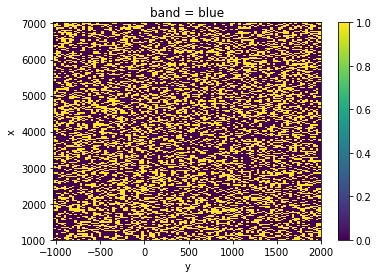

In [7]:
yp = gs.predict(X)
yp = yp.unstack("sample")
yp.plot.imshow()

In [8]:
# predict labels
yp = gs.predict(X)
yp.values = LabelEncoder().fit(X.land_use).classes_[yp]
yp = yp.unstack("sample")
print(yp)

<xarray.DataArray (x: 200, y: 100)>
array([['forest', 'water', 'forest', ..., 'forest', 'forest', 'forest'],
       ['forest', 'forest', 'forest', ..., 'water', 'forest', 'water'],
       ['forest', 'forest', 'forest', ..., 'forest', 'water', 'forest'],
       ...,
       ['water', 'forest', 'forest', ..., 'forest', 'water', 'water'],
       ['water', 'water', 'forest', ..., 'forest', 'water', 'forest'],
       ['forest', 'water', 'forest', ..., 'forest', 'forest', 'forest']],
      dtype='<U6')
Coordinates:
    band      <U4 'blue'
    land_use  (x, y) <U6 'forest' 'water' 'forest' ... 'forest' 'forest'
  * x         (x) float64 1.015e+03 1.045e+03 1.075e+03 ... 6.985e+03 7.015e+03
  * y         (y) float64 1.985e+03 1.955e+03 1.924e+03 ... -984.7 -1.015e+03
